In [2]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import findspark
findspark.init()

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev,count
from scipy.stats import ks_2samp
import pandas as pd
import matplotlib.pyplot as plt

In [16]:

from pyspark.sql.types import *
import time

In [ ]:
# 1. Инициализация Spark
spark = SparkSession.builder \
    .appName("Parquet_Drift_Analysis_Fixed") \
    .config("spark.hadoop.fs.s3a.access.key", "access_key") \
    .config("spark.hadoop.fs.s3a.secret.key", "secret_key") \
    .config("spark.hadoop.fs.s3a.endpoint", "storage.yandexcloud.net") \
    .config("spark.sql.parquet.filterPushdown", "true") \
    .getOrCreate()

In [18]:
# 2. Определение схемы
transaction_schema = StructType([
    StructField("transaction_id", IntegerType()),
    StructField("tx_datetime", TimestampType()),
    StructField("customer_id", IntegerType()),
    StructField("terminal_id", IntegerType()),
    StructField("tx_amount", DoubleType()),
    StructField("tx_time_seconds", IntegerType()),
    StructField("tx_time_days", IntegerType()),
    StructField("tx_fraud", IntegerType()),
    StructField("tx_fraud_scenario", IntegerType())
])

In [19]:
# 3. Функция для чтения Parquet с проверкой
def read_parquet_safe(path):
    try:
        df = spark.read.schema(transaction_schema).parquet(path)
        print(f"Успешно загружен: {path.split('/')[-1]}")
        print(f"Количество строк: {df.count():,}")
        return df
    except Exception as e:
        print(f"Ошибка загрузки {path}: {str(e)}")
        return None

In [20]:
# 4. Расчет метрик дрифта
def calculate_drift(prev_df, current_df, column="tx_amount"):
    # Базовые статистики
    prev_stats = prev_df.select(
        mean(col(column)).alias("mean"),
        stddev(col(column)).alias("stddev"),
        count(col(column)).alias("count")
    ).collect()[0]
    
    current_stats = current_df.select(
        mean(col(column)).alias("mean"),
        stddev(col(column)).alias("stddev"),
        count(col(column)).alias("count")
    ).collect()[0]
    
    # KS-тест на выборке
    sample_size = min(10000, int(prev_stats["count"]*0.1))
    prev_sample = prev_df.select(column).sample(False, 0.1).limit(sample_size).toPandas()[column]
    current_sample = current_df.select(column).sample(False, 0.1).limit(sample_size).toPandas()[column]
    
    ks_stat, p_value = ks_2samp(prev_sample, current_sample)
    
    return {
        "ks_stat": float(ks_stat),
        "p_value": float(p_value),
        "prev_mean": float(prev_stats["mean"]),
        "current_mean": float(current_stats["mean"]),
        "mean_diff": float(current_stats["mean"] - prev_stats["mean"])
    }


In [21]:
# 5. Список файлов для анализа
parquet_paths = [
    "s3a://fraud-detection-data-otus-2025/parquet/2019-08-22",
    "s3a://fraud-detection-data-otus-2025/parquet/2019-09-21",
    "s3a://fraud-detection-data-otus-2025/parquet/2019-10-21"
]

In [22]:
# 6. Основной анализ
results = []
for i in range(1, len(parquet_paths)):
    prev_path = parquet_paths[i-1]
    current_path = parquet_paths[i]
    
    print(f"\nСравнение: {prev_path.split('/')[-1]} vs {current_path.split('/')[-1]}")
    
    prev_df = read_parquet_safe(prev_path)
    current_df = read_parquet_safe(current_path)
    
    if prev_df and current_df:
        metrics = calculate_drift(prev_df, current_df)
        results.append({
            "comparison": f"{prev_path.split('/')[-1]} → {current_path.split('/')[-1]}",
            **metrics
        })



Сравнение: 2019-08-22 vs 2019-09-21
Успешно загружен: 2019-08-22
Количество строк: 46,988,419
Успешно загружен: 2019-09-21
Количество строк: 46,994,587

Сравнение: 2019-09-21 vs 2019-10-21
Успешно загружен: 2019-09-21
Количество строк: 46,994,587
Успешно загружен: 2019-10-21
Количество строк: 46,994,433


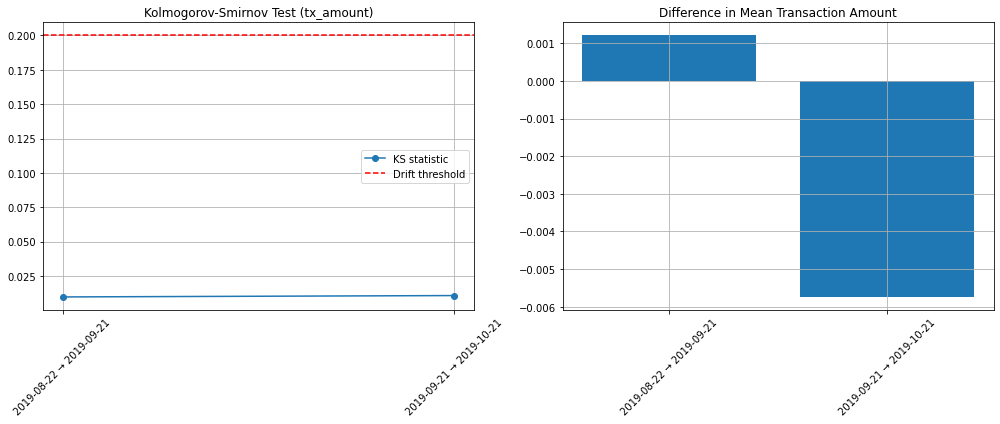


Результаты сохранены в drift_analysis_results.csv
                comparison  ks_stat   p_value  prev_mean  current_mean  \
0  2019-08-22 → 2019-09-21   0.0097  0.734599   54.23396      54.23517   
1  2019-09-21 → 2019-10-21   0.0107  0.616085   54.23517      54.22943   

   mean_diff  
0    0.00121  
1   -0.00574  


In [23]:
# 7. Визуализация результатов
if results:
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(14, 6))
    
    # График KS статистики
    plt.subplot(1, 2, 1)
    plt.plot(results_df['ks_stat'], 'o-', label='KS statistic')
    plt.axhline(y=0.2, color='r', linestyle='--', label='Drift threshold')
    plt.title('Kolmogorov-Smirnov Test (tx_amount)')
    plt.xticks(ticks=range(len(results_df)), labels=results_df['comparison'], rotation=45)
    plt.legend()
    plt.grid()
    
    # График изменения среднего
    plt.subplot(1, 2, 2)
    plt.bar(results_df['comparison'], results_df['mean_diff'])
    plt.title('Difference in Mean Transaction Amount')
    plt.xticks(rotation=45)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # Сохранение результатов
    results_df.to_csv("drift_analysis_results.csv", index=False)
    print("\nРезультаты сохранены в drift_analysis_results.csv")
    print(results_df)
else:
    print("\nНе удалось получить результаты дрифта")

In [ ]:


spark.stop()